In [14]:
# Standard Libraries
import pandas as pd
import re
import string
from google.colab import files

# Natural Language Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# SKlearn Libraries
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim Libraries
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Visualisation libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Downloading NLTK Packages
nltk.download(["stopwords", "wordnet", "punkt"])

# Define Stop Words
stop_words = list(stopwords.words("english"))

# Add Custom Stop Words
new_words = [
    "british",
    "airway",
    "company",
    "airline",
    "flight",
    "heathrow",
    "service",
    "london",
    "business",
    "economy",
    "customer",
    "passenger",
    "hour",
    "minute",
]
stop_words.extend(new_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Load data

In [15]:
def load_data() -> pd.DataFrame:
    """
    The function:
    - uploads the data from local machine
    - read the data from csv file to df
    - samples 20% of the data
    """
    # Prompt user to upload a the reviews csv file
    uploaded = files.upload()
    # Read the data from csv
    data = pd.read_csv("reviews.csv")
    data = data[["ReviewBody"]]
    # Sample 20% of the data
    data = data.sample(frac=0.20, random_state=42).reset_index(drop=True)
    return data

In [16]:
# Load the data
df_reviews = load_data()

Saving reviews.csv to reviews (1).csv


### 2. Data Preprocessing

In [17]:
def preprocess_text(text: str) -> list:
    """
    This function prepares the text data, conducting the following steps:
    1) Removal of text in sqaure brackets
    2) Removal of words containing numbers
    3) Tokenization
    4) Lemmatization
    5) Removal of stopwords
    6) Removal of punctuation and short words
    """
    # Remove text in square brackets
    text = re.sub(r"\[.*?\]", "", text)
    # Remove special characters such as emojis
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    # Remove words containing numbers
    text = re.sub(r"\b\w*\d\w*\b", "", text)
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stop words and punctuation
    processed_tokens = [
        token
        for token in lemmatized_tokens
        if token.lower() not in stop_words
        and token not in string.punctuation
        and len(token) > 5
    ]
    return processed_tokens

In [18]:
# Preprocess the data
df_reviews["ReviewBody"] = df_reviews.ReviewBody.apply(lambda x: preprocess_text(x))

### 3. Bag of words (BoW) and LDA (Gensim)

In [19]:
def apply_lda_with_bag_of_words(df_reviews: pd.DataFrame) -> pd.DataFrame:
    """
    This function applies LDA from gensim with bag of words approach.
    """
    # Map IDs to words to be used as an input for the LDA model using the universal corpous ids
    words = corpora.Dictionary(df_reviews["ReviewBody"])

    # Turn each review into a bag of words.
    corpus = [words.doc2bow(doc) for doc in df_reviews["ReviewBody"]]

    # Apply the LDA model from gensim to establish topics
    lda_bag_of_words_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,  # text
        id2word=words,  # representations
        num_topics=6,  # define number of topics
        random_state=42,
    )

    feature_names_bag_of_words = list(
        words.values()
    )  # get the features names from Bag of Words
    n_top_words = 10

    # Initialize a dictionary to store dominant words per LDA topic group
    topics_dict = {}

    for topic_idx, topic in enumerate(lda_bag_of_words_model.get_topics()):
        topic_words = [
            feature_names_bag_of_words[i]
            for i in topic.argsort()[: -n_top_words - 1 : -1]
        ]
        topics_dict[f"Topic {(topic_idx + 1)}"] = topic_words

    # Turn the dict of topics/words into df
    lda_bag_of_words_model_topics_df = pd.DataFrame(topics_dict)

    return (
        feature_names_bag_of_words,
        lda_bag_of_words_model,
        lda_bag_of_words_model_topics_df,
    )

In [20]:
# Apply Gensim LDA with BoW approach
(
    feature_names_bag_of_words,
    lda_bag_of_words_model,
    lda_with_bag_of_words_topics_df,
) = apply_lda_with_bag_of_words(df_reviews)

In [21]:
def visualize_topics(model_method: str, feature_names: list, n_top_words: int) -> None:
    """
    Visualizes topics generated by a topic modeling method using word clouds.
    """
    # Create subplots for each topic
    fig, axes = plt.subplots(
        nrows=2, ncols=3, figsize=(16, 8), sharex=True, sharey=True
    )
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model_method):
        # Generate word cloud for each topic
        wordcloud = WordCloud(background_color="white", colormap="viridis").generate(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
            )
        )
        ax = axes[topic_idx]
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f"Topic {topic_idx + 1}", fontsize=16)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

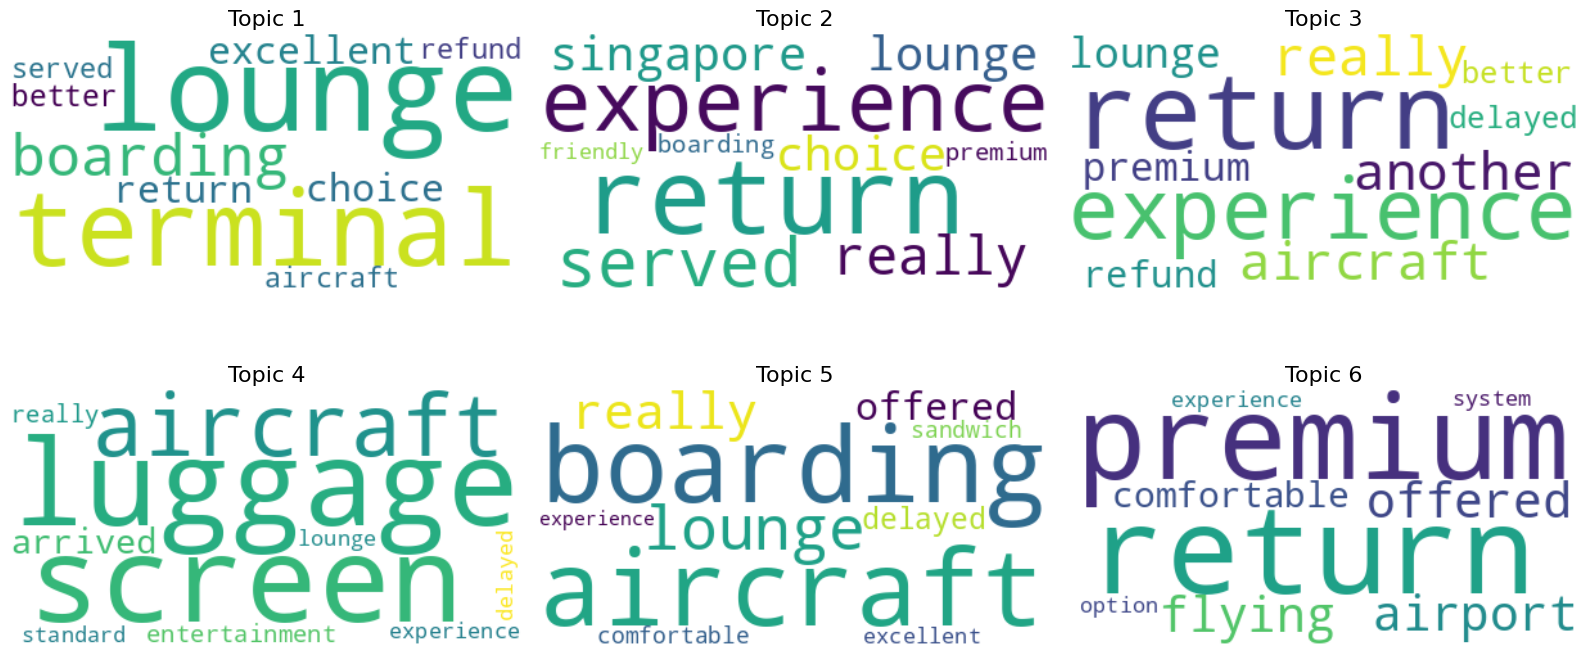

In [22]:
# Visualise Gensim LDA with BoW topics
visualize_topics(
    lda_bag_of_words_model.get_topics(), feature_names_bag_of_words, n_top_words=10
)

## Topics from LDA (Gensim) and BoW Method
1) Lounge

2) Crew experience

3) Flight returns and refunds

4) Luggage

5) Boarding

6) Departures and flight times

### 4. TFIDF and LDA (scikit-learn)

In [23]:
def apply_lda_with_tfidf(df_reviews):
    """
    This function applies LDA from scikit-learn with tfidf approach.
    """
    # Initialize TFIDF
    tfidf = TfidfVectorizer(max_df=0.8, min_df=20, max_features=10000)
    # Convert the text column to a list of strings
    df_reviews["ReviewBody_tokenized"] = df_reviews["ReviewBody"].apply(
        lambda x: " ".join(x)
    )
    # Fit the TF-IDF vectorizer to the text data
    X = tfidf.fit_transform(df_reviews["ReviewBody_tokenized"])
    # Run LDA
    lda_model_with_tfidf = LatentDirichletAllocation(
        n_components=6, random_state=123  # define number of topics
    )
    lda_model_with_tfidf.fit_transform(X)

    n_top_words = 10  # define numbers of words per topics
    feature_names_tfidf = (
        tfidf.get_feature_names_out()
    )  # extract features names from TFIDF

    # Initialize a dictionary to store dominant words per LDA topic group
    topics_dict = {}

    for topic_idx, topic in enumerate(lda_model_with_tfidf.components_):
        topic_words = [
            feature_names_tfidf[i] for i in topic.argsort()[: -n_top_words - 1 : -1]
        ]
        topics_dict[f"Topic {(topic_idx + 1)}"] = topic_words

    # Turn the dict of topics/words into df
    lda_tfidf_topics_df = pd.DataFrame(topics_dict)
    return feature_names_tfidf, lda_model_with_tfidf, lda_tfidf_topics_df

In [24]:
# Apply Sklearn LDA with TFIDF approach
feature_names_tfidf, lda_model_with_tfidf, lda_tfidf_topics_df = apply_lda_with_tfidf(
    df_reviews
)

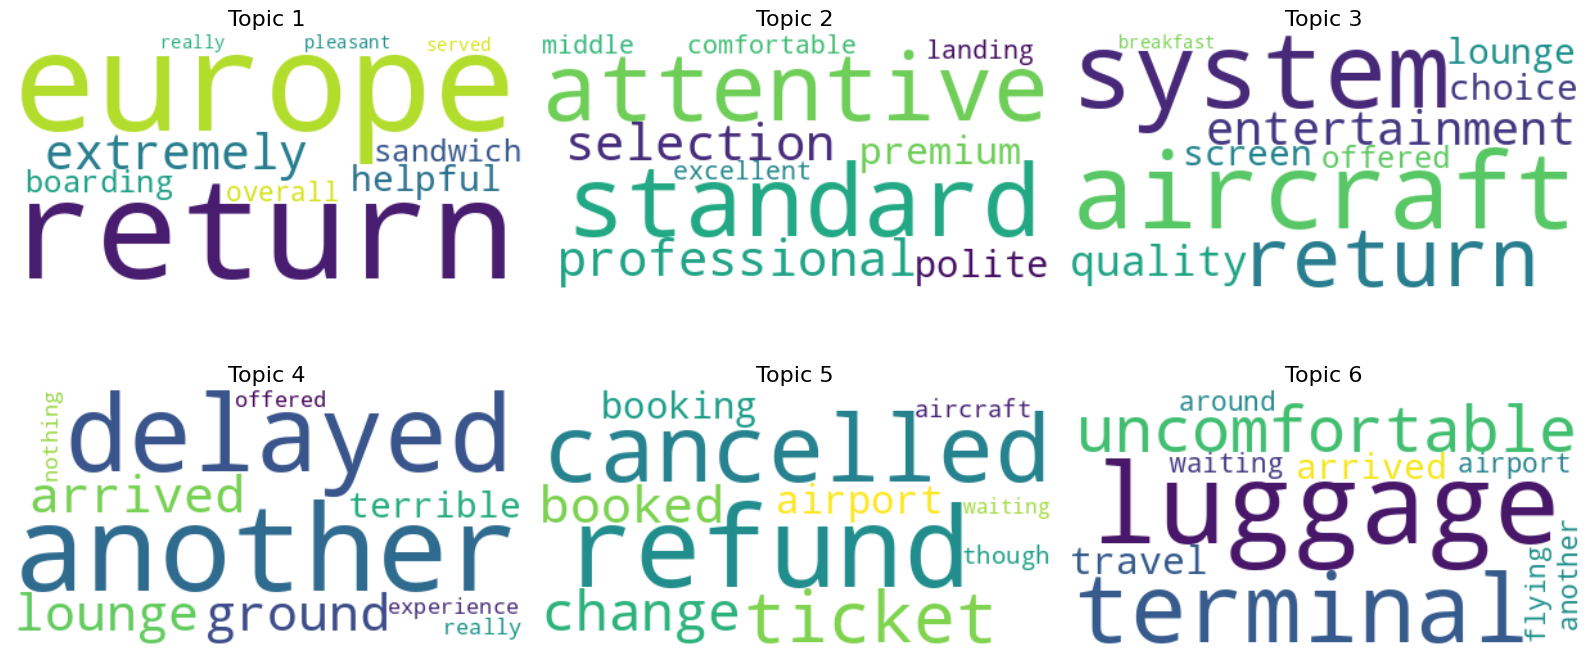

In [25]:
# Visualise Sklearn LDA with TFIDF topics
visualize_topics(lda_model_with_tfidf.components_, feature_names_tfidf, n_top_words=10)

## Topics from LDA and TFIDF Method

1) Boarding

2) Cabin and crew experience

3) Entertaiment

4) Flight times

5) Bookings, refunds, and cacellations

6) Luggage handling and delays

## **Final list of Topics based on business judgment:**

1) Boarding and Crew Experience

2) Entertainment and Food

3) Cabin Comfort and Baggage

4) Lounge Experience

5) Bookings and Refunds

6) Flights and Cancellations